In [1]:
import torch
from torch.utils.data import Dataset
import json
import numpy as np
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from math import sqrt
from time import time
import argparse

In [2]:
!dir

flow.zip  path.zip  poi.zip  sample_data  time.npy  weather-final.npy


In [3]:
!unzip flow.zip
!unzip path.zip
!unzip poi.zip

Archive:  flow.zip
  inflating: flow/flow_bike_nyc_irregular.json  
  inflating: flow/flow_bike_nyc_regular.json  
Archive:  path.zip
  inflating: path/irregular_path.npy  
  inflating: path/regular_path.npy   
Archive:  poi.zip
  inflating: poi/irregular_feature.npy  
  inflating: poi/irregular_idx.npy   
  inflating: poi/irregular_label.npy  
  inflating: poi/irregular_weight.npy  
  inflating: poi/regular_feature.npy  
  inflating: poi/regular_idx.npy     
  inflating: poi/regular_label.npy   
  inflating: poi/regular_weight.npy  


In [4]:
class PopulationDataset(Dataset):

    def __init__(self,
                 division='regular',
                 T=5,
                 type='train'):
        len_t = 24 * (31 + 31 + 30)
        N = len_t - T
        N_train = int(N * 0.8)
        N_val = int(N * 0.1)
        N_test = int(N * 0.1)
        weekend = [i for i in range(1, 93, 7)] + [i for i in range(2, 93, 7)] + [4, 66]
        T_SLOT = 24
        C = 2
        if division == 'regular':
            H = 16
            W = 8
            num_node = H * W
            raw_data = json.load(open("flow/flow_bike_nyc_regular.json"))
        elif division == 'irregular':
            num_node = 82
            raw_data = json.load(open("flow/flow_bike_nyc_irregular.json"))

        dataset = np.zeros((C, len_t, num_node), dtype=np.float32)
        data1 = raw_data['inflow']
        data2 = raw_data['outflow']


        weather = np.load("/content/weather-final.npy")
        time = np.load("/content/time.npy")

        for node_no in range(num_node):
            dataset[0, :, node_no] = np.array(data1[str(node_no)])
            dataset[1, :, node_no] = np.array(data2[str(node_no)])

        if type == 'train':
            xy = np.zeros((N_train, C, T + 1, num_node), dtype=np.float32)
            x_t = np.zeros((N_train, T), dtype=np.int64)
            w_t = np.zeros((N_train, T + 1, weather.shape[1]), dtype=np.float32)
            t_t = np.zeros((N_train, T + 1, time.shape[1]), dtype=np.float32)

            for t in range(N_train):
                xy[t, :, :, :] = dataset[:, t:t + T + 1, :]
                w_t[t,:] = weather[t:t + T + 1,:]
                t_t[t,:] = time[t:t + T + 1,:]
                if (t + T + 1) // T_SLOT + 1 in weekend:
                    x_t[t, :] = np.arange(t, t + T) % T_SLOT + T_SLOT
                else:
                    x_t[t, :] = np.arange(t, t + T) % T_SLOT

        elif type == 'val':
            xy = np.zeros((N_val, C, T + 1, num_node), dtype=np.float32)
            x_t = np.zeros((N_val, T), dtype=np.int64)
            w_t = np.zeros((N_val, T + 1, weather.shape[1]), dtype=np.float32)
            t_t = np.zeros((N_val, T + 1, time.shape[1]), dtype=np.float32)

            for t in range(N_train, N_train + N_val):
                xy[t - N_train, :, :, :] = dataset[:, t:t + T + 1, :]
                w_t[t- N_train,:] = weather[t:t + T + 1,:]
                t_t[t- N_train,:] = time[t:t + T + 1,:]
                if (t + T + 1) // T_SLOT + 1 in weekend:
                    x_t[t - N_train, :] = np.arange(t, t + T) % T_SLOT + T_SLOT
                else:
                    x_t[t - N_train, :] = np.arange(t, t + T) % T_SLOT

        elif type == 'test':
            xy = np.zeros((N_test, C, T + 1, num_node), dtype=np.float32)
            x_t = np.zeros((N_test, T), dtype=np.int64)
            w_t = np.zeros((N_test, T + 1, weather.shape[1]), dtype=np.float32)
            t_t = np.zeros((N_test, T + 1, time.shape[1]), dtype=np.float32)

            for t in range(N_train + N_val, N_train + N_val + N_test):
                xy[t - N_train - N_val, :, :, :] = dataset[:, t:t + T + 1, :]
                w_t[t - N_train - N_val,:] = weather[t:t + T + 1,:]
                t_t[t - N_train - N_val,:] = time[t:t + T + 1,:]
                if (t + T + 1) // T_SLOT + 1 in weekend:
                    x_t[t - N_train - N_val, :] = np.arange(t, t + T) % T_SLOT + T_SLOT
                else:
                    x_t[t - N_train - N_val, :] = np.arange(t, t + T) % T_SLOT

        self.x_data = torch.from_numpy(xy[:, :, 0:-1, :])
        self.x_t = torch.from_numpy(x_t)
        self.w_t = torch.from_numpy(w_t[:,0:-1,:])
        self.t_t = torch.from_numpy(t_t[:,0:-1,:])
        self.y_data = torch.from_numpy(xy[:, :, -1, :])
        self.len = xy.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.x_t[index], self.y_data[index], self.w_t[index], self.t_t[index]

    def __len__(self):
        return self.len

# Model

In [20]:
class Model(nn.Module):

    def __init__(self,
                 division='regular',
                 C=2,
                 K=9,
                 T=5):
        super(Model, self).__init__()

        self.T_SLOT = 24
        self.K = K
        self.T = T
        self.Gamma = 1

        A = np.load('path/' + division + '_path.npy')
        A_0 = A[:, :, :, 0]
        A_sum = np.sum(A[:, :, :, 1:], axis=3)
        for i in range(1, K + 1):
            A[:, :, :, i] = A_sum
        self.A = torch.Tensor(A)

        feature = np.load('poi/' + division + '_feature.npy').astype(np.float32)

        feature_size = np.size(feature, 1)
        V = np.size(feature, 0)
        self.F = torch.Tensor(feature)
        self.A_mean = torch.Tensor(np.mean(A_0 + A_sum, axis=0)).permute(1, 0).contiguous()
        self.I = torch.ones(V, V, 1)

        self.networks = nn.ModuleList([
            DGCN(C_in=C, C_out=32, kernel_size=(2 * self.Gamma + 1, K + 1)),
            DGCN(C_in=32, C_out=64, kernel_size=(2 * self.Gamma + 1, K + 1)),
            DGCN(C_in=64, C_out=32, kernel_size=(2 * self.Gamma + 1, K + 1)),
            DGCN(C_in=32, C_out=16, kernel_size=(2 * self.Gamma + 1, K + 1)),
        ])

        self.gru = nn.GRU(input_size=8, hidden_size=2, num_layers=8, batch_first=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(T, 1), stride=(1, 1))

        self.semi1 = nn.Linear(feature_size, 16)
        self.semi2 = nn.Linear(16, K)
        self.LeakyReLU = nn.LeakyReLU()
        self.Softmax = nn.Softmax()
        self.temporal_conv = nn.Conv2d(16, C, kernel_size=(T, 1))
        self.gru_conv = nn.Conv2d(1, C, kernel_size=(T, 1))
        self.maxpool_conv = nn.Conv2d(16, C, kernel_size=(1, 1))
        self.gru_time = nn.GRU(input_size=2, hidden_size=2, num_layers=1, batch_first=True)
        self.weights = nn.Parameter(torch.rand(4))
        self.conv1d_layer = nn.Conv1d(in_channels = 2, out_channels=2, kernel_size=3, stride=1, padding=1)

    def forward(self, x, x_t, idx, w_t, t_t):
        N, C, T, V = x.size()
        last = x[:, :, -1, :]
        Y1 = self.LeakyReLU(torch.mm(self.A_mean, self.semi1(self.F)))
        Y2 = self.LeakyReLU(torch.mm(self.A_mean, self.semi2(Y1)))
        Y = torch.index_select(Y2, 0, idx)
        Z = self.Softmax(Y2)
        A_K = self.A * torch.cat((self.I, Z.repeat(V, 1, 1)), dim=2).repeat(self.T_SLOT * 2, 1, 1, 1)
        x_t = x_t.view(N * T)
        x_A = torch.index_select(A_K, 0, x_t)
        x_A = x_A.view(N, T, V, V, -1)
        for dgcn in self.networks:
            x = dgcn(x, x_A)
        # Perform maxpool on input X
        output3 = self.maxpool(x)
        output3 = self.maxpool_conv(output3)
        output3 = output3.squeeze(-2)
        # Temporal convolution on input X
        x = self.temporal_conv(x)
        output1 = x.view(N,-1,V)
        # Gru for weather data
        output2, _ = self.gru(w_t)
        output2 = output2.unsqueeze(0)
        output2 = output2.permute(1,0,2,3)
        output2 = self.gru_conv(output2)
        output2 = output2.view(N,-1,2)
        output2 = output2[:, :, 0:1]
        output2 = output2.squeeze(-1)
        output2 = output2.unsqueeze(2)
        # Gru for time data
        output4, _ = self.gru_time(t_t)
        output4 = output4.unsqueeze(0)
        output4 = output4.permute(1,0,2,3)
        output4 = self.gru_conv(output4)
        output4 = output4.view(N,-1,2)
        output4 = output4[:, :, 0:1]
        output4 = output4.squeeze(-1)
        output4 = output4.unsqueeze(2)
        # weights calculation
        weighted_tensor1 = output1 * self.weights[0]
        weighted_tensor2 = output2 * self.weights[1]
        weighted_tensor3 = output3 * self.weights[2]
        weighted_tensor4 = output4 * self.weights[3]
        # weighted fusion
        weighted_fusion_tensor = weighted_tensor1 + weighted_tensor2 + weighted_tensor3 + weighted_tensor4
        # Compute the gating factor
        gate_factor = 0.8
        #print(gate_factor)
        fused_features = gate_factor * output1 + (1 - gate_factor) * (weighted_tensor2 + weighted_tensor3 + weighted_tensor4) + weighted_fusion_tensor
        # resulted tensor
        result = fused_features + last
        result = self.conv1d_layer(result)
        return result, Y


class DGCN(nn.Module):

    def __init__(self,
                 C_in,
                 C_out,
                 kernel_size):
        super(DGCN, self).__init__()

        self.K = kernel_size[1] - 1
        self.C_out = C_out
        self.conv = nn.Sequential(nn.BatchNorm3d(C_in),
                                  nn.ReLU(inplace=True),
                                  nn.Conv3d(C_in,
                                            C_out,
                                            kernel_size=(kernel_size[0], 1, kernel_size[1]),
                                            padding=(1, 0, 0),
                                            stride=(1, 1, 1),
                                            bias=True),
                                  nn.BatchNorm3d(C_out),
                                  nn.Dropout3d(p=0.2, inplace=True))

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, x_A):

        N, C, T, V = x.size()

        x_reshape = x.permute(0, 2, 1, 3).contiguous().view(N * T, C, V)
        A_reshape = x_A.view(N * T, V, V * (self.K + 1)).contiguous()
        x = torch.bmm(x_reshape, A_reshape).view(N, T, C, V, (self.K + 1)).permute(0, 2, 1, 3, 4).contiguous()
        x = self.conv(x).view(N, self.C_out, T, V)

        return self.relu(x)


## main Block

In [21]:
def train(model, train_loader, optimizer, criterion, epoch, label, label_idx, label_weight, theta):
    model.train()
    train_loss = 0
    # Define the weight decay (L2 regularization) hyperparameter
    weight_decay = 0.001
    # Calculate the regularization term
    regularization_loss = 0

    for batch_idx, (data, x_t, target, w_t, t_t) in enumerate(train_loader):
        data, x_t, target, w_t, t_t = Variable(data).cuda(), Variable(x_t).cuda(), Variable(target).cuda(), Variable(w_t).cuda(), Variable(t_t).cuda()
        optimizer.zero_grad()
        output, y = model(data, x_t, label_idx, w_t, t_t)
        loss1 = criterion(output, target)
        loss2 = nn.functional.cross_entropy(y, label, weight=label_weight)
        for param in model.parameters():
               regularization_loss += torch.norm(param, 2)
        loss = loss1 + loss2 * theta + weight_decay * regularization_loss.item()

        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            #print ("Hello ",epoch, batch_idx, len(data), len(train_loader.dataset),100*batch_idx/len(train_loader),loss1.data.item())
            print ("Epoch: %d [%d/%d (%.0f%%)]\tLoss: %.6f\tLabel Loss: %.6f" % (epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), sqrt(loss1.data.item()), loss2.data.item()))
        train_loss += loss1.data.item() * len(data)
    return sqrt(train_loss/ len(train_loader.dataset))


def val(model, val_loader, criterion, epoch, label_idx):
    model.eval()
    val_loss = 0
    absolute_errors = 0  # Variable to store the sum of absolute errors
    squared_errors = 0
    num_samples = 0
    for batch_idx, (data, x_t, target, w_t, t_t) in enumerate(val_loader):
        data, x_t, target, w_t, t_t = Variable(data).cuda(), Variable(x_t).cuda(), Variable(target).cuda(), Variable(w_t).cuda(), Variable(t_t).cuda()
        output, _ = model(data, x_t, label_idx, w_t, t_t)
        loss = criterion(output, target)
        val_loss += loss.data.item() * len(data)
         # Calculate absolute and squared errors
        absolute_errors += torch.sum(torch.abs(output - target)).item()/164
        squared_errors += torch.sum((output - target) ** 2).item()/164

        num_samples += len(data)

    print ("\nEpoch: %d \tVal Loss: %.6f" % (epoch, sqrt(val_loss / len(val_loader.dataset))))
    val_mae = absolute_errors / len(val_loader.dataset)
    val_rmse = sqrt(squared_errors / len(val_loader.dataset))
    val_loss = sqrt(val_loss / len(val_loader.dataset))

    return val_loss, val_mae, val_rmse


def test(model, test_loader, criterion, epoch, label_idx):
    model.eval()
    test_loss = 0
    absolute_errors = 0  # Variable to store the sum of absolute errors
    squared_errors = 0
    num_samples = 0
    for batch_idx, (data, x_t, target, w_t, t_t) in enumerate(test_loader):
        data, x_t, target, w_t, t_t = Variable(data).cuda(), Variable(x_t).cuda(), Variable(target).cuda(), Variable(w_t).cuda(), Variable(t_t).cuda()
        output, _ = model(data, x_t, label_idx, w_t, t_t)
        loss = criterion(output, target)
        test_loss += loss.data.item()* len(data)
         # Calculate absolute and squared errors
        absolute_errors += torch.sum(torch.abs(output - target)).item()/164
        squared_errors += torch.sum((output - target) ** 2).item()/164

        num_samples += len(data)

    print ("Epoch: %d \tTest Loss: %.6f\n" % (epoch, sqrt(test_loss / len(test_loader.dataset))))
    test_mae = absolute_errors / len(test_loader.dataset)
    test_rmse = sqrt(squared_errors / len(test_loader.dataset))
    test_loss = sqrt(test_loss / len(test_loader.dataset))


    return test_loss, test_mae, test_rmse

## main Function

In [22]:
class Args:
  batch = 64
  test_batch = 32
  epoch = 1600
  lr = 0.001
  seed = 1
  division = 'irregular'
  K = 9
  C = 2
  T = 5
  theta = 10
  load = 0

args=Args()

In [ ]:
def main():

    train_loader = torch.utils.data.DataLoader(PopulationDataset(division=args.division,
                                                                 T=args.T,
                                                                 type='train'),
                                               batch_size=args.test_batch,
                                               shuffle=True)

    val_loader = torch.utils.data.DataLoader(PopulationDataset(division=args.division,
                                                               T=args.T,
                                                               type='val'),
                                             batch_size=args.test_batch,
                                             shuffle=False)

    test_loader = torch.utils.data.DataLoader(PopulationDataset(division=args.division,
                                                                T=args.T,
                                                                type='test'),
                                              batch_size=args.test_batch,
                                              shuffle=False)

    model = Model(division=args.division,
                  C=args.C,
                  K=args.K,
                  T=args.T)

    torch.cuda.set_device(0)
    torch.manual_seed(args.seed)
    model = model.cuda()

    model.A = Variable(model.A).cuda()
    model.F = Variable(model.F).cuda()
    model.A_mean = Variable(model.A_mean).cuda()
    model.I = Variable(model.I).cuda()

    label = np.load('poi/' + args.division + '_label.npy').astype(np.int64)
    label_idx = np.load('poi/' + args.division + '_idx.npy').astype(np.int64)
    label_weight = np.load('poi/' + args.division + '_weight.npy').astype(np.float32)

    label = torch.from_numpy(label[label_idx])
    label_idx = torch.from_numpy(label_idx)
    label_weight = torch.from_numpy(label_weight)
    label = Variable(label).cuda()
    label_idx = Variable(label_idx).cuda()
    label_weight = Variable(label_weight).cuda()

    if args.load > 0:
        model.load_state_dict(torch.load('checkpoint/epoch_' + str(args.load) + '.tar'))

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.SmoothL1Loss(size_average=True)
    loss = np.zeros((3, args.epoch), dtype=np.float32)
    mae = np.zeros((2, args.epoch), dtype=np.float32)
    rmse = np.zeros((2, args.epoch), dtype=np.float32)

    val_loss_min = 100
    test_loss_min = 100

    for epoch in range(1 + args.load, args.epoch + 1 + args.load):
        start = time()
        train_loss = train(model, train_loader, optimizer, criterion, epoch, label, label_idx, label_weight, args.theta)
        stop = time()
        print ("Time used: %.0f" % (stop - start))
        loss[0, epoch - args.load - 1] = train_loss

        with torch.no_grad():
          val_loss, val_mae, val_rmse = val(model, val_loader, criterion, epoch, label_idx)
          test_loss, test_mae, test_rmse = test(model, test_loader, criterion, epoch, label_idx)
          loss[1, epoch - args.load - 1] = val_loss
          loss[2, epoch - args.load - 1] = test_loss
          mae[0, epoch - args.load - 1] = val_mae
          mae[1, epoch - args.load - 1] = test_mae
          rmse[0, epoch - args.load - 1] = val_rmse
          rmse[1, epoch - args.load - 1] = test_rmse
          if val_loss < val_loss_min:
            val_loss_min = val_loss
            test_loss_min = test_loss
        if epoch % 100 == 0:
            torch.save(model.state_dict(), 'checkpoint/epoch_' + str(epoch) + '.tar')

    np.save('checkpoint/loss.npy', loss)
    np.save('checkpoint/mae.npy', mae)
    np.save('checkpoint/rmse.npy', rmse)
    #np.save('checkpoint/valmae.npy', val_mae')
    # print("Val RMSE: %.4f \tTest RMSE: %.4f\n" % (
    #     val_loss_min, test_loss_min))
    weights = model.weights
    print(weights)
    print("Val RMSE: %.4f \tTest RMSE: %.4f\n" % (val_loss_min, test_loss_min))


if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
<ipython-input-20-cb1fea87c705>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Z = self.Softmax(Y2)


Epoch: 1 [0/1762 (0%)]	Loss: 7.521389	Label Loss: 2.217490
Epoch: 1 [640/1762 (36%)]	Loss: 5.698050	Label Loss: 2.172324
Epoch: 1 [1280/1762 (71%)]	Loss: 6.486360	Label Loss: 2.145652
Time used: 2

Epoch: 1 	Val Loss: 6.793042
Epoch: 1 	Test Loss: 6.626428

Epoch: 2 [0/1762 (0%)]	Loss: 5.710090	Label Loss: 2.119770
Epoch: 2 [640/1762 (36%)]	Loss: 6.178201	Label Loss: 2.085419
Epoch: 2 [1280/1762 (71%)]	Loss: 5.794003	Label Loss: 2.051570
Time used: 2

Epoch: 2 	Val Loss: 6.129508
Epoch: 2 	Test Loss: 5.972206

Epoch: 3 [0/1762 (0%)]	Loss: 5.584425	Label Loss: 1.998629
Epoch: 3 [640/1762 (36%)]	Loss: 5.279066	Label Loss: 1.940767
Epoch: 3 [1280/1762 (71%)]	Loss: 5.473064	Label Loss: 1.881267
Time used: 2

Epoch: 3 	Val Loss: 5.599814
Epoch: 3 	Test Loss: 5.449750

Epoch: 4 [0/1762 (0%)]	Loss: 4.753785	Label Loss: 1.825627
Epoch: 4 [640/1762 (36%)]	Loss: 4.703258	Label Loss: 1.754292
Epoch: 4 [1280/1762 (71%)]	Loss: 4.928685	Label Loss: 1.696511
Time used: 2

Epoch: 4 	Val Loss: 5.146949

In [10]:
import numpy as np

In [11]:
loss= np.load('/content/checkpoint/loss.npy')
mae= np.load('/content/checkpoint/mae.npy')
rmse= np.load('/content/checkpoint/rmse.npy')

In [12]:
print(loss.shape)
print(mae.shape)
print(rmse.shape)

(3, 500)
(2, 500)
(2, 500)


In [13]:
# Separate the train, val, and test losses
train_loss = loss[0]
val_loss = loss[1]
test_loss = loss[2]
val_mae = mae[0]
test_mae = mae[1]
val_rmse = rmse[0]
test_rmse =rmse[1]

In [14]:
import matplotlib.pyplot as plt

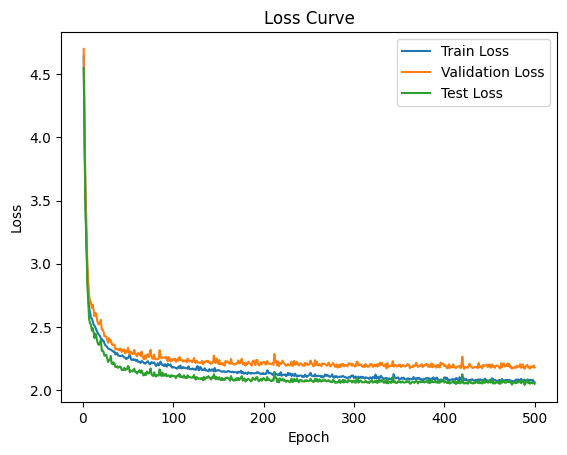

In [15]:
x = np.arange(1, len(train_loss) + 1)

# Plot the loss curve
plt.plot(x, train_loss, label='Train Loss')
plt.plot(x, val_loss, label='Validation Loss')
plt.plot(x, test_loss, label='Test Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Add legend
plt.legend()
#plt.savefig('loss_curve.pdf', bbox_inches='tight', pad_inches=0)
# Display the plot
plt.show()

In [16]:
print(test_rmse)

[38.29261   29.592548  23.075424  20.342754  16.345213  14.859886
 13.655584  13.424133  13.468412  12.538648  13.329694  12.464248
 11.892604  11.913853  12.246434  11.595763  11.197999  11.170232
 11.429033  11.140147  10.766544  10.8912945 10.583759  10.249196
  9.973234  10.043572   9.818309   9.611392   9.907135   9.788819
  9.730468   9.415091   9.371181   9.428025   9.49327    9.038944
  8.975831   9.120616   9.047525   8.993817   9.130395   9.015184
  8.678345   8.961069   8.7483425  8.980591   8.631939   8.870977
  8.836063   9.137798   8.867652   8.585568   8.772852   8.698452
  8.660291   8.647028   8.851661   8.5959635  8.518499   8.508242
  8.699988   8.629612   8.767946   8.465278   8.847163   8.459124
  8.295985   8.321022   8.520564   8.363457   8.549309   8.490455
  8.450747   8.65487    8.8563     8.464931   8.269133   8.251918
  8.518839   8.308069   8.21812    8.256586   8.274407   8.249439
  8.777693   8.364843   8.241424   8.451571   8.297095   8.451069
  8.338262

In [17]:
print(train_loss[-1])
print(val_loss[-1])
print(test_loss[-1])

2.060541
2.1784139
2.0491564


In [18]:
print(val_mae[-1])
print(test_mae[-1])

5.1942244
4.6461205


In [19]:
print(val_rmse[-1])
print(test_rmse[-1])

9.517656
7.705837


In [75]:
# Calculate MSE
mse_train = np.mean(train_loss)
mse_val = np.mean(val_loss)
mse_test = np.mean(test_loss)

# Calculate MAE
#mae_train = np.mean(np.abs(train_loss))
mae_val = np.mean(val_mae)
mae_test = np.mean(test_mae)

# Calculate RMSE
#rmse_train = np.sqrt(mse_train)
rmse_val = np.mean(val_rmse)
rmse_test = np.mean(test_rmse)

# Print the results
print("MSE - Train: {:.4f}, Validation: {:.4f}, Test: {:.4f}".format(mse_train, mse_val, mse_test))
print("MAE - Validation: {:.4f}, Test: {:.4f}".format( mae_val, mae_test))
print("RMSE - Validation: {:.4f}, Test: {:.4f}".format( rmse_val, rmse_test))

MSE - Train: 2.2033, Validation: 2.2878, Test: 2.1453
MAE - Validation: 5.8074, Test: 5.1713
RMSE - Validation: 10.8471, Test: 8.7623
